# NYC Airbnb Price Prediction - Deep Learning model training

Use dataset published by Kaggle - https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data - to train a simple deep learning model to predict prices for Airbnb properties.

This notebook contains the code to train the model from the dataset prepared in the airbnb_data_preparation notebook. 


# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#buildpipe>Build pipeline</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

# Common imports and global variable definitions

In [1]:

''' check to see if the notebook is being run in Colab, and if so, set the current directory appropriately'''
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_basics/notebooks

Mounted at /content/drive
/content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_basics/notebooks


In [2]:
import time
start_time = time.time()

In [3]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import seaborn as sns
# import datetime, timedelta
import datetime
import pydotplus
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from pickle import dump
from pickle import load
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
import yaml
import math
import sys
from subprocess import check_output
from IPython.display import display
#model libraries
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
#from tf.keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.python.keras.callbacks import TensorBoard
#import datetime
#from datetime import date
from sklearn import metrics
# import pipeline libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from custom_classes import encode_categorical
from custom_classes import prep_for_keras_input
from custom_classes import fill_empty
from custom_classes import encode_text


In [4]:
import tensorflow as tf
tf.__version__ 

'2.8.2'

In [5]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, 'model_training_config.yml')
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')


current directory is: /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_basics/notebooks
path_to_yaml /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_basics/notebooks/model_training_config.yml


In [6]:
# load parameters

repeatable_run = config['test_parms']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if repeatable_run:
    from numpy.random import seed
    seed(4)
    tf.random.set_seed(7)


testproportion = config['test_parms']['testproportion'] # proportion of data reserved for test set
trainproportion = config['test_parms']['trainproportion'] # proportion of non-test data dedicated to training (vs. validation)
get_test_train_acc = config['test_parms']['get_test_train_acc']
verboseout = config['general']['verboseout']
includetext = config['general']['includetext'] # switch to determine whether text columns are included in the model
save_model_plot = config['general']['save_model_plot'] # switch to determine whether to generate plot with plot_model
tensorboard_callback = config['general']['tensorboard_callback'] # switch to determine if tensorboard callback defined

presaved = config['general']['presaved']
savemodel = config['general']['savemodel']
picklemodel = config['general']['picklemodel']
hctextmax = config['general']['hctextmax']
maxwords = config['general']['maxwords']
textmax = config['general']['textmax']

targetthresh = config['general']['targetthresh']
targetcontinuous = config['general']['targetcontinuous']
target_col = config['general']['target_col']

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}



emptythresh = config['general']['emptythresh']
zero_weight = config['general']['zero_weight']
one_weight = config['general']['one_weight']
one_weight_offset = config['general']['one_weight_offset']
patience_threshold = config['general']['patience_threshold']


# modifier for saved model elements
modifier = config['general']['modifier']

# control whether training controlled by early stop
early_stop = True

# default hyperparameter values
learning_rate = config['hyperparameters']['learning_rate']
dropout_rate = config['hyperparameters']['dropout_rate']
l2_lambda = config['hyperparameters']['l2_lambda']
loss_func = config['hyperparameters']['loss_func']
output_activation = config['hyperparameters']['output_activation']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['epochs']

# date values
date_today = datetime.now()
print("date today",date_today)

# pickled original dataset and post-preprocessing dataset
pickled_data_file = config['general']['pickled_data_file']
pickled_dataframe = config['general']['pickled_dataframe']

# experiment parameter

current_experiment = config['test_parms']['current_experiment']

# load lists of column categories
collist = config['categorical']
textcols = config['text']
continuouscols = config['continuous']
excludefromcolist = config['excluded']

date today 2022-09-20 20:42:47.374132


# Helper functions

In [7]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}


def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)




In [8]:
# get the paths required

def get_path():
    '''get the path for data files

    Returns:
        path: path for data files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

def get_pipeline_path():
    '''get the path for data files
    
    Returns:
        path: path for pipeline files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'pipelines'))
    return(path)

def get_model_path():
    '''get the path for data files
    
    Returns:
        path: path for model files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [9]:
def set_experiment_parameters(experiment_number, count_no_delay, count_delay):
    ''' set the appropriate parameters for the experiment 
    Args:
        experiment_number: filename containing config parameters
        count_no_delay: count of negative outcomes in the dataset
        count_delay: count of positive outcomes in the dataset

    Returns:
        early_stop: whether the experiment includes an early stop callback
        one_weight: weight applied to positive outcomes
        epochs: number of epochs in the experiment
        es_monitor: performance measurement tracked in callbacks
        es_mod: direction of performance being tracked in callbacks
    
    '''
    print("setting parameters for experiment ", experiment_number)
    # default settings for early stopping:
    es_monitor = "val_loss"
    es_mode = "min"
    if experiment_number == 0:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 1
    elif experiment_number == 9:
        #
        early_stop = True
        es_monitor="val_accuracy"
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        get_test_train_acc = False
        #
        epochs = 20    
    elif experiment_number == 1:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 10
    elif experiment_number == 2:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 50
    elif experiment_number == 3:
        #
        early_stop = False
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 4:
        #
        early_stop = True
        es_monitor = "val_loss"
        es_mode = "min"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 5:
        #
        early_stop = True
        # if early stopping fails because the level of TensorFlow/Python, comment out the following
        # line and uncomment the subsequent if statement
        es_monitor="val_accuracy"
        '''
        if sys.version_info >= (3,7):
            es_monitor="val_accuracy"
        else:
            es_monitor = "val_acc"
        '''
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    else:
        early_stop = True
    return(early_stop, one_weight, epochs,es_monitor,es_mode)






# Ingest data and create refactored dataframe <a name='ingestdash' />
- Ingest data for route information and delay information
- Create refactored dataframe with one row per route / direction / timeslot combination


<a href=#linkanchor>Back to link list</a>

In [10]:
def ingest_data(path):
    '''load list of valid routes and directions into dataframe
    Args:
        path: path for data files
    
    Returns:
        merged_data: dataframe loaded from pickle file
    '''
    file_name = os.path.join(path,pickled_dataframe)
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(merged_data)

In [11]:
def prep_merged_data(merged_data,target_col):
    '''add derived columns to merged_data dataframe
    Args:
        merged_data: input dataframe
        target_col: column that is the target
    
    Returns:
        merged_data: dataframe with derived columns added
    '''
    if targetcontinuous:
        merged_data['target'] = merged_data[target_col]
    else:
        merged_data['target'] = np.where(merged_data[target_col] >= merged_data[target_col].mean(), 1, 0 )
    return(merged_data)

# Master Prep Cell
Contains calls to functions to load data, prep input dataframes, and create refactored dataframe

In [12]:
# master calls

path = get_path()
print("path is",path)
# load route direction and delay data datframes
merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data,target_col)
print("shape of pre refactored dataset", merged_data.shape)
#merged_data['year'].value_counts()
#merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)
# create refactored dataframe with one row for each route / direction / timeslot combination
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count under mean ",count_no_delay)
print("count over mean ",count_delay)
# define parameters for the current experiment
experiment_number = current_experiment
early_stop, one_weight, epochs,es_monitor,es_mode = set_experiment_parameters(experiment_number, count_no_delay, count_delay)
print("early_stop is ",early_stop)
print("one_weight is ",one_weight)
print("epochs is ",epochs)
print("es_monitor is ",es_monitor)
print("es_mode is ",es_mode)

path is /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_basics/data
shape of pre refactored dataset (48895, 18)
shape of refactored dataset (48895, 18)
count under mean  34016
count over mean  14879
setting parameters for experiment  5
early_stop is  True
one_weight is  2.2861751461791786
epochs is  50
es_monitor is  val_accuracy
es_mode is  max


In [13]:
merged_data.shape

(48895, 18)

# Define training, validation, and test subsets of the dataset

In [14]:
def get_train_validation_test(dataset):
    '''get training and test data set
    Args:
        dataset: input dataframe
    
    Returns:
        dtrain: training subset of dataset
        dvalid: validation subset of dataset
        dtest: test subset of dataset
    '''
    train, test = train_test_split(dataset, test_size = testproportion)
    dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)
    print("Through train test split. Test proportion:")
    print(testproportion)
    return(dtrain,dvalid,test)



# Build Pipeline <a name='buildpipe' />

Create pipeline objects to perform final data preparation steps for training and inference.

Note that cleanup on the training dataset is completed upstream in the [data cleanup notebook](https://github.com/ryanmark1867/end_to_end_deep_learning_liveproject/blob/master/notebooks/data_cleanup.ipynb). 
- The pipelines only accomplish the subset of preparation that is required for both training and inference
- Because the scoring data coming in for inference is forced by the web deployment to avoid the invalid values that the data cleanup notebook deals with, the pipelines don't have to deal with those problems.

<a href=#linkanchor>Back to link list</a>

In [15]:
print("collist is: ",str(collist))
print("textcols is: ",str(textcols))
print("continuouscols is: ",str(continuouscols))
print("excludefromcolist is: ",str(excludefromcolist))

collist is:  ['neighbourhood_group', 'neighbourhood', 'room_type']
textcols is:  []
continuouscols is:  ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']
excludefromcolist is:  ['price', 'id', 'latitude', 'longitude', 'host_name', 'last_review', 'name', 'host_name', 'availability_365']


In [16]:
# master block to invoke pipeline

# build fully qualified names for the files for saving the pipelines
pipeline_path = get_pipeline_path()
pipeline1_file_name = os.path.join(pipeline_path,'sc_delay_pipleline'+modifier+'.pkl')
pipeline2_file_name = os.path.join(pipeline_path,'sc_delay_pipleline_keras_prep'+modifier+'.pkl')

# define column lists:
# collist,continuouscols,textcols = def_col_lists()

# create objects of the pipeline classes
fe = fill_empty()
ec = encode_categorical()
pk = prep_for_keras_input()
pk_valid = prep_for_keras_input()
pk_test = prep_for_keras_input()

# need to implement the pipeline in two parts:
# 1. fill empty + encode categoricals
# 2. prep for Keras
# because part 1 needs to be applied to the entire dataset and part 2 to the individual train, validate, and test sets


sc_delay_pipeline = Pipeline([('fill_empty',fe),('encode_categorical',ec)])
# need to have distinct pipeline objects for each subset of the dataset: train, validated and test
sc_delay_pipeline_keras_prep = Pipeline([('prep_for_keras',pk)])
sc_delay_pipeline_keras_prep_valid = Pipeline([('prep_for_keras',pk_valid)])
sc_delay_pipeline_keras_prep_test = Pipeline([('prep_for_keras',pk_test)])



# provide the value for each parameter of each of the pipeline classes

sc_delay_pipeline.set_params(fill_empty__collist = collist, fill_empty__continuouscols = continuouscols,
                            fill_empty__textcols = textcols,encode_categorical__col_list = collist)
sc_delay_pipeline_keras_prep.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)
sc_delay_pipeline_keras_prep_valid.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)
sc_delay_pipeline_keras_prep_test.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)

# fit the input dataset to the pipeline

# first fit the first segment of pipeline on the whole dataset
X = sc_delay_pipeline.fit_transform(merged_data)
max_dict = ec.max_dict
# then split dataset
dump(sc_delay_pipeline, open(pipeline1_file_name,'wb'))
dump(sc_delay_pipeline_keras_prep, open(pipeline2_file_name,'wb'))
dtrain, dvalid, test = get_train_validation_test(X)
# then apply second portion of pipeline to each subset
# need to have a distinct object for each to prevent first object impacting others

X_train_list = sc_delay_pipeline_keras_prep.fit_transform(dtrain)
X_valid_list = sc_delay_pipeline_keras_prep_valid.fit_transform(dvalid)
X_test_list = sc_delay_pipeline_keras_prep_test.fit_transform(test)

print("keras variables defined")
print("X_train_list",X_train_list)



fill empty xform
col is  neighbourhood_group
col is  neighbourhood
col is  room_type
transform col is  neighbourhood_group
after transform col is  neighbourhood_group
transform col is  neighbourhood
after transform col is  neighbourhood
transform col is  room_type
after transform col is  room_type
Through train test split. Test proportion:
0.2
cat col is neighbourhood_group
cat col is neighbourhood
cat col is room_type
cont col is minimum_nights
cont col is number_of_reviews
cont col is reviews_per_month
cont col is calculated_host_listings_count
cat col is neighbourhood_group
cat col is neighbourhood
cat col is room_type
cont col is minimum_nights
cont col is number_of_reviews
cont col is reviews_per_month
cont col is calculated_host_listings_count
cat col is neighbourhood_group
cat col is neighbourhood
cat col is room_type
cont col is minimum_nights
cont col is number_of_reviews
cont col is reviews_per_month
cont col is calculated_host_listings_count
keras variables defined
X_train_l

In [17]:
len(X_train_list[0])

31292

In [18]:
len(dtrain.target)

31292

In [19]:
len(X_valid_list[0])

7824

In [20]:
len(dvalid)

7824

# Define and fit model <a name='modelfit' />

- define the architecture of the model - the layers determined by the type (categorical, continuous, or text) of each column
- apply callbacks
- fit the model

<a href=#linkanchor>Back to link list</a>

In [21]:
# define model in Keras

def get_model():
    ''' define Keras model by specifying layers by column type
    
    Returns:
        model: Keras model with the layers specified by the structure of the dataset

    '''

    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings


    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])



    # define layers for text columns
    if includetext:
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col]))
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")

    # define layers for continuous columns
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])



    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])

    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])

    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])

    print("main_l", main_l)



    # define output layer
    output = Dense(1, activation=output_activation) (main_l)

    # define model

    model = Model(inputlayerlist, output)


    # define optimizer
    optimizer = SGD(lr=learning_rate)

    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    # model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy", Recall(), Precision()], weighted_metrics=["accuracy"])
    


    return model


model = get_model()

# output model summary

model.summary()




about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l KerasTensor(type_spec=TensorSpec(shape=(None, 34), dtype=tf.float32, name=None), name='concatenate_5/concat:0', description="created by layer 'concatenate_5'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 neighbourhood_group (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 neighbourhood (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding (Em

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [22]:
# save model plot
if save_model_plot:
    model_plot_file = "model_plot"+modifier+".png"
    model_plot_path = os.path.join(get_path(),model_plot_file)
    print("model plot path: ",model_plot_path)
    plot_model(model, to_file=model_plot_path)

In [23]:
# set up early stopping
def set_early_stop(es_monitor, es_mode):
    ''' given monitoring parameter es_monitor and mode es_mode, define early stopping callback, save model callback, and 
    TensorBoard callback
    
    Args:
        es_monitor: the performance parameter to monitor in the callback
        es_mode: the extremity (max or min) to optimize towards
        
    Returns:
        callback_list: list of callback objects
        save_model_path: fully qualified filename to save optimal model to  
    
    
    '''
    # define callback for early stopping
    callback_list = []
    es = EarlyStopping(monitor=es_monitor, mode=es_mode, verbose=1,patience = patience_threshold)
    callback_list.append(es)
    model_path = get_model_path()
    save_model_path = os.path.join(model_path,'scmodel'+modifier+"_"+str(experiment_number)+'.h5')
    # define callback to save best model
    mc = ModelCheckpoint(save_model_path, monitor=es_monitor, mode=es_mode, verbose=1, save_best_only=True)
    callback_list.append(mc)
    # define callback for TensorBoard
    if tensorboard_callback:
        tensorboard_log_dir = os.path.join(get_path(),"tensorboard_log",datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard = TensorBoard(log_dir= tensorboard_log_dir)
        callback_list.append(tensorboard)
    return(callback_list,save_model_path)

In [24]:
%%time
# master block to define callbacks & model and fit model 
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",batch_size)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)
print("patience_threshold is ",patience_threshold)
print("experiment number is ",experiment_number)
print("early stop is",early_stop)
# get definitions of callbacks
callback_list, save_model_path = set_early_stop(es_monitor, es_mode)
# define model
model = get_model()
# if callbacks are specified 
if early_stop:
       modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
        , validation_data=(X_valid_list, dvalid.target), verbose=1,callbacks=callback_list)
else:
    modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
         , validation_data=(X_valid_list, dvalid.target), verbose=1)

text cols []
dropout  0.0003
L2 lambda  0.0003
batch size  1000
epochs 50
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
patience_threshold is  3
experiment number is  5
early stop is True
about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l KerasTensor(type_spec=TensorSpec(shape=(None, 34), dtype=tf.float32, name=None), name='concatenate_11/concat:0', description="created by layer 'concatenate_11'")
Epoch 1/50
29/32 [==========================>...] - ETA: 0s - loss: 2.6545 - accuracy: 0.7083 - weighted_accuracy: 0.7083
Epoch 1: val_accuracy improved from -inf to 0.70616, saving model to /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_basics/models/scmodelsep3_2022_5.h5
32/32 [==============================] - 3s 39ms/step - loss: 2.6285 - accuracy: 0.7101 - weighted_accuracy: 0.7101 - val_loss: 2.6449 - val_accuracy: 0.7062 - val_weighted_accuracy: 0.

In [25]:
# block to save model elements explicitly if not saved as part of early_stop
if early_stop == False:
    model_json = model.to_json()
    model_path = get_model_path()
    with open(os.path.join(model_path,'model'+modifier+'.json'), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.path.join(model_path,'scweights'+modifier+'.h5'))
    save_model_path = os.path.join(model_path,'scmodel'+modifier+'.h5')
    model.save(save_model_path,save_format='h5')
    # no early stop, so make current model saved_model
    saved_model = model
    print("Saved model, weights to disk")


In [26]:
# block to load saved model and get test and train accuracy
saved_model = load_model(save_model_path)
print("metrics names ",saved_model.metrics_names)
# getting test and train accuracy is time consuming - check to see if experiment requires it
if get_test_train_acc:
    if len(saved_model.metrics_names) == 2:
        # saved_model.evaluate returns ['loss', 'acc']
        _, train_acc = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
        _, test_acc = saved_model.evaluate(X_test_list, test.target, verbose=0)
    else:
        # saved_model.evaluate returns ['loss', 'accuracy', 'accuracy_1']
        _, train_acc,_ = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
        _, test_acc,_ = saved_model.evaluate(X_test_list, test.target, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))




metrics names  ['loss', 'accuracy', 'weighted_accuracy']
Train: 0.741, Test: 0.733


In [27]:
X_train_list

[array([2, 1, 1, ..., 2, 2, 2]),
 array([197, 158,  51, ...,  94, 201,  64]),
 array([0, 1, 0, ..., 1, 0, 0]),
 array([1, 1, 3, ..., 2, 3, 1]),
 array([ 2, 11,  3, ..., 12,  0,  0]),
 array([0.05, 0.3 , 1.18, ..., 0.36, 0.  , 0.  ]),
 array([1, 2, 1, ..., 1, 1, 1])]

In [28]:
X_train_list[0]

array([2, 1, 1, ..., 2, 2, 2])

# Predictions and renderings

In [29]:
list(X_test_list[0])

[2,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 3,
 1,
 2,
 1,
 2,
 3,
 1,
 0,
 1,
 1,
 3,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 3,
 3,
 2,
 2,
 1,
 4,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 3,
 3,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 2,
 3,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 3,
 2,
 3,
 1,
 3,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 3,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 2,
 0,
 3,
 1,
 2,
 1,
 3,
 2,
 3,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 3,
 1,
 3,
 3,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 3,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 3,
 1,
 1,
 3,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 3,
 2,
 2,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 1,


In [30]:
# predictions on training set

preds = saved_model.predict(X_test_list, batch_size=batch_size)

In [31]:
preds.shape

(9779, 1)

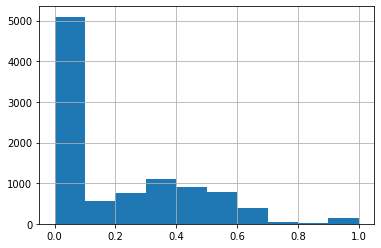

In [32]:
test["predict"] = preds
test.predict[:5]
if verboseout:
    test.predict.hist()

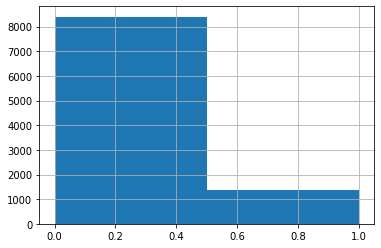

In [33]:
if verboseout:
    test.predict.hist(bins=2)

In [34]:
# get rounded predictions
test["predround"] = preds.round().astype(int)
test.predround[:5]

43580    1
7763     0
15701    0
4079     0
28383    0
Name: predround, dtype: int64

In [35]:
print("test target 0",test[test['target']==0].shape[0])
print("test target 1",test[test['target']==1].shape[0])
print("test predround 0",test[test['predround']==0].shape[0])
print("test predround 1",test[test['predround']==1].shape[0])

test target 0 6815
test target 1 2964
test predround 0 8403
test predround 1 1376


In [36]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(test.target[:100000] - test.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct test")
print((len(deltatr) - deltatr.sum())/len(deltatr))



2610
percentage correct test
0.7331015441251661


In [37]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid_list, batch_size=batch_size)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





931      0.246671
7720     0.633068
47252    0.735032
32025    0.682329
46018    1.000000
Name: predict, dtype: float32

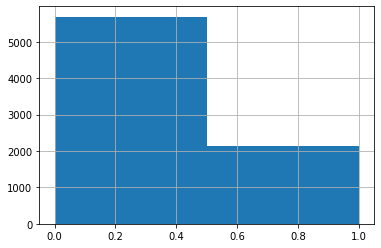

In [38]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [39]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


931      1
7720     1
47252    1
32025    0
46018    1
12908    0
8385     0
9281     1
280      0
3744     0
Name: deltaval, dtype: int64
2121


In [40]:
# hand calculation of proportion correct guesses in validation set

test["deltaval"] = abs(test.target - test.predround)
print(test["deltaval"][:10])
print(test["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))

43580    0
7763     0
15701    0
4079     0
28383    0
45099    0
11160    0
20974    0
5874     0
44943    0
Name: deltaval, dtype: int64
2610


In [41]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,"(latitude, longitude)",target,predround,predict,deltaval
931,350168,Artist 2BR in Park Slope w/backyard,1774431,Kate,1,151,40.67725,-73.98210,0,178,...,8,2018-01-02,0.10,1,280,"(40.67725, -73.9821)",1,0,0.246671,1
7720,5846654,HUGE 1BR on the Upper East Side,30354449,Avraham,2,201,40.77139,-73.95766,0,110,...,3,2016-02-14,0.07,1,0,"(40.77139, -73.95766)",0,1,0.633068,1
47252,35655950,Gorgeous Super Clean Guest Suite,80443454,Kathryn,3,110,40.71708,-73.82411,1,74,...,10,2019-07-07,10.00,1,160,"(40.71708, -73.82411)",0,1,0.735032,1
46018,35033521,Shared room in Midtown Near Times Square 5,263880607,Ahmet,2,95,40.76356,-73.98814,2,77,...,2,2019-06-23,1.62,7,362,"(40.76356, -73.98814)",0,1,1.000000,1
9281,7091660,1BR in large apt on Lower East Side,37170055,Sara,2,119,40.72348,-73.99095,1,250,...,0,2019-01-01,0.00,1,1,"(40.72348, -73.99095)",1,0,0.370637,1
23957,19322515,20m to Manhattan - 2 Floors + Express Subway,98705818,Mari,1,51,40.67476,-73.93016,0,550,...,6,2019-05-22,0.25,1,249,"(40.67476, -73.93016)",1,0,0.441838,1
17091,13549611,Bright and cozy apt next to park,59575555,Para,1,52,40.68144,-73.89416,0,75,...,2,2016-08-15,0.06,1,0,"(40.68144, -73.89416)",0,1,0.596858,1
1017,413775,Midtown East Sutton Area Entire Apt,2058589,Cary,2,127,40.75816,-73.96457,0,275,...,16,2019-05-09,0.24,1,167,"(40.75816, -73.96457)",1,0,0.325171,1
17016,13515087,"Cute&Cozy Apartment, 20 min to Grand Central",10743221,Masha,3,4,40.77164,-73.92028,0,98,...,0,2019-01-01,0.00,1,0,"(40.77164, -73.92028)",0,1,0.589159,1
9550,7331835,Bright Studio heart of LES,23851015,Suwan,2,119,40.72157,-73.98489,0,130,...,0,2019-01-01,0.00,1,0,"(40.72157, -73.98489)",0,1,0.731516,1


In [42]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
testwrong = test.loc[(test.deltaval == 1)]
testright = test.loc[(test.deltaval == 0)]
testwrong.head(20)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,"(latitude, longitude)",target,predict,predround,deltaval
8743,6713521,Your Garden Oasis in Brooklyn!,1401919,Mike,1,13,40.68447,-73.95430,0,275,...,21,2018-11-24,0.44,1,5,"(40.68447, -73.9543)",1,0.000000,0,1
48172,36115258,Sunlit Design Loft 2bdroom,271663737,Jesse,1,214,40.70612,-73.95549,0,99,...,0,2019-01-01,0.00,1,297,"(40.70612, -73.95549)",0,0.629699,1,1
23159,18750465,Beautiful studio in midtown Manhattan,120762452,Stanley,2,137,40.74863,-73.97670,0,150,...,0,2019-01-01,0.00,50,365,"(40.74863, -73.9767)",0,0.654773,1,1
40322,31269983,Lux Condo Room Close to Manhattan. WiFi & Balc...,137358866,Kazuya,3,220,40.74181,-73.90279,1,61,...,0,2019-01-01,0.00,103,123,"(40.74181, -73.90279)",0,0.713315,1,1
31729,24737425,Charming Lux. 1 bedroom in Williamsburg,4350342,Samantha,1,214,40.71160,-73.95137,0,225,...,21,2019-06-23,1.60,1,88,"(40.7116, -73.95137)",1,0.000000,0,1
36919,29340345,Sams place,178337703,Samuel,0,39,40.80504,-73.85327,1,300,...,1,2018-10-21,0.11,1,364,"(40.80504, -73.85327)",1,0.316498,0,1
22401,18091600,Amazingly Charming 2 BR in Historic Harlem,709334,Julie,2,94,40.80353,-73.94707,0,250,...,14,2019-04-17,0.55,2,296,"(40.80353, -73.94707)",1,0.000000,0,1
5453,3946018,Luxury Building in Time Square,20449160,Mark,2,191,40.75977,-73.98763,0,189,...,57,2019-07-07,1.18,1,9,"(40.75977, -73.98763)",1,0.000000,0,1
13356,10033868,NICE 2 BED APT NEAR TIME SQUARE,51501835,Jeniffer,2,95,40.76244,-73.99295,0,166,...,7,2019-01-03,0.18,31,195,"(40.76244, -73.99295)",1,0.000000,0,1
24901,19963733,"Prewar duplex, 3 bedrooms, minutes from everyt...",93355703,Katherine,1,25,40.69677,-73.99599,0,585,...,10,2019-02-18,0.42,1,225,"(40.69677, -73.99599)",1,0.000000,0,1


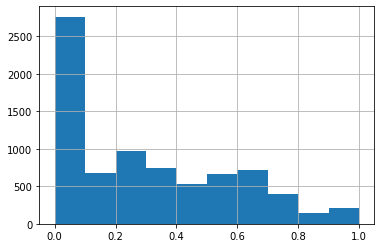

In [43]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

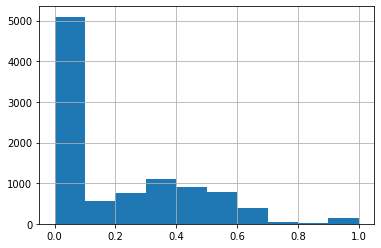

In [44]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
test.predict.hist()

In [45]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


2121
percentage correct validate
0.7289110429447853


dict_keys(['loss', 'accuracy', 'weighted_accuracy', 'val_loss', 'val_accuracy', 'val_weighted_accuracy'])


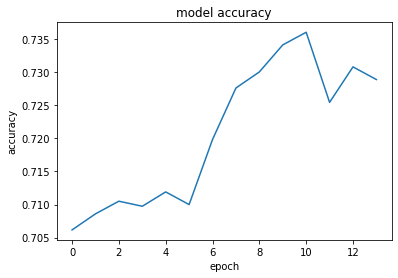

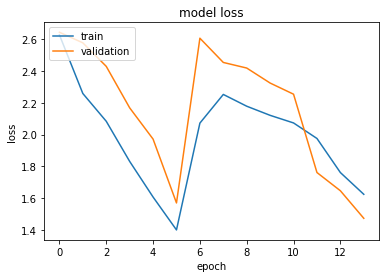

In [46]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
#plt.plot(modelfit.history['accuracy'])
plt.plot(modelfit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
#plt.legend(['validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

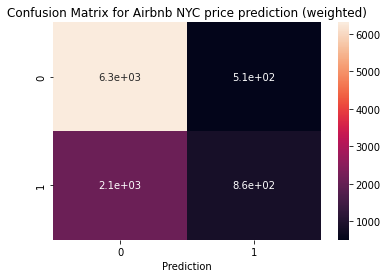

In [47]:


cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=test["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for Airbnb NYC price prediction (weighted)")
plt.show()

In [48]:
model.metrics_names

['loss', 'accuracy', 'weighted_accuracy']

In [49]:
# print elapsed time to run the notebook
print("--- %s seconds ---" % (time.time() - start_time))

--- 19.717823028564453 seconds ---


# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl